In [135]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN


The structure of this section will be as so. I will consider 3 classes of IVP problem: \
\
• $y' = -y, y(0)=1$. This has the solution $y = e^{-x}$\
• $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$\
• $y' = \cos x, y(0) = 0$. This has the solution $y = \sin x$


The structure will be as follows. For each of these classes of subproblem, I will first see how 3 models each with different activation functions performs on these problems, varying number of hidden layers and number of neurons per hidden layer. Each of those results will be scaled and then we can see how varying the learning rate affects the solutions too. For the first case I'll see how the function fits to the region, and then examine how they fit outside the region too. 

For the second case, we will examine how they deal with a singularity. Likely extremely poorly. Similar approach though, and we shall see how they perform.
Third case, we will examine how they deal with a periodic function.

In [136]:
# Here we define the relevant functions to train the IVP for this first problem

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

# Loss function for the ODE and initial condition
def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx + y ≈ 0
    ode_residual = dy_dx + y_pred
    loss_ode = torch.mean(ode_residual**2)

    # Initial condition loss
    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma*loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, epochs=2000, lr=1e-3, n_collocation=100, domain=(0.0, 1.0), verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_collocation = x_collocation.requires_grad_(True)

    # Initial condition remains at x = 0
    x_ic = torch.tensor([[domain[0]]], requires_grad=True)
    y_ic = torch.tensor([[1.0]])

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, ODE = {loss_ode:.6f}, IC = {loss_ic:.6f}")
        loss_history.append(loss.item())

    return loss_history

    


Epoch 0: Total Loss = 48.146404, ODE = 0.017747, IC = 0.962573
Epoch 100: Total Loss = 0.051248, ODE = 0.046682, IC = 0.000091
Epoch 200: Total Loss = 0.024347, ODE = 0.024332, IC = 0.000000
Epoch 300: Total Loss = 0.013770, ODE = 0.013764, IC = 0.000000
Epoch 400: Total Loss = 0.008822, ODE = 0.008820, IC = 0.000000
Epoch 500: Total Loss = 0.006397, ODE = 0.006395, IC = 0.000000
Epoch 600: Total Loss = 0.004975, ODE = 0.004974, IC = 0.000000
Epoch 700: Total Loss = 0.003981, ODE = 0.003980, IC = 0.000000
Epoch 800: Total Loss = 0.003204, ODE = 0.003204, IC = 0.000000
Epoch 900: Total Loss = 0.002568, ODE = 0.002567, IC = 0.000000
Epoch 1000: Total Loss = 0.002042, ODE = 0.002042, IC = 0.000000
Epoch 1100: Total Loss = 0.001614, ODE = 0.001614, IC = 0.000000
Epoch 1200: Total Loss = 0.001277, ODE = 0.001277, IC = 0.000000
Epoch 1300: Total Loss = 0.001020, ODE = 0.001020, IC = 0.000000
Epoch 1400: Total Loss = 0.000832, ODE = 0.000832, IC = 0.000000
Epoch 1500: Total Loss = 0.000699, O

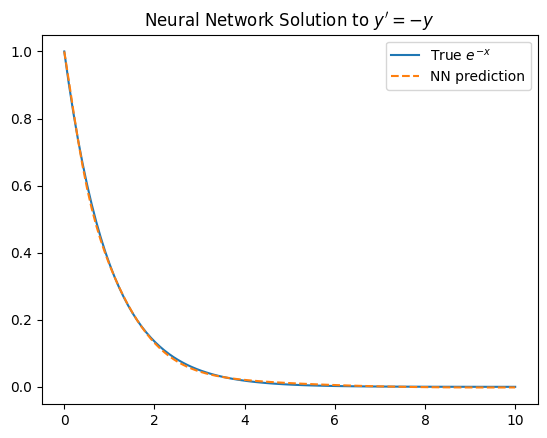

In [137]:
# sense_check above functions work
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=2, hidden_units=20, activation='tanh')

# Train
loss_history = train_ivp(model, epochs=2000, lr=1e-3, gamma=50, domain=(0.0, 10.0))

# Plot prediction vs true
x_test = torch.linspace(0, 10, 100).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test)
y_true = torch.exp(-x_test)

plt.plot(x_test, y_true, label='True $e^{-x}$')
plt.plot(x_test, y_pred, '--', label='NN prediction')
plt.legend()
plt.title("Neural Network Solution to $y' = -y$")
plt.show()

In [138]:
# Now I will evaluate the best structure for fitting to this simple structure.
activations = ['tanh', 'relu']
layer_counts = [i for i in range(1, 11)]
widths = [i for i in range(1, 21)]

# Tracking results
results = []

# Loop through configurations
for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            
            start = time.time()
            train_ivp(model, epochs=2500, lr=1e-2, verbose=False)  # you can adjust epochs/lr

            # Evaluate MSE on training domain
            x_eval = torch.linspace(0, 1, 100).view(-1, 1)
            y_true = torch.exp(-x_eval)
            with torch.no_grad():
                y_pred = model(x_eval)
                mse = torch.mean((y_pred - y_true)**2).item()
            duration = time.time() - start

            # Store results
            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("Data/IVP_data/exponential_decay_results.csv", index=False)

Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

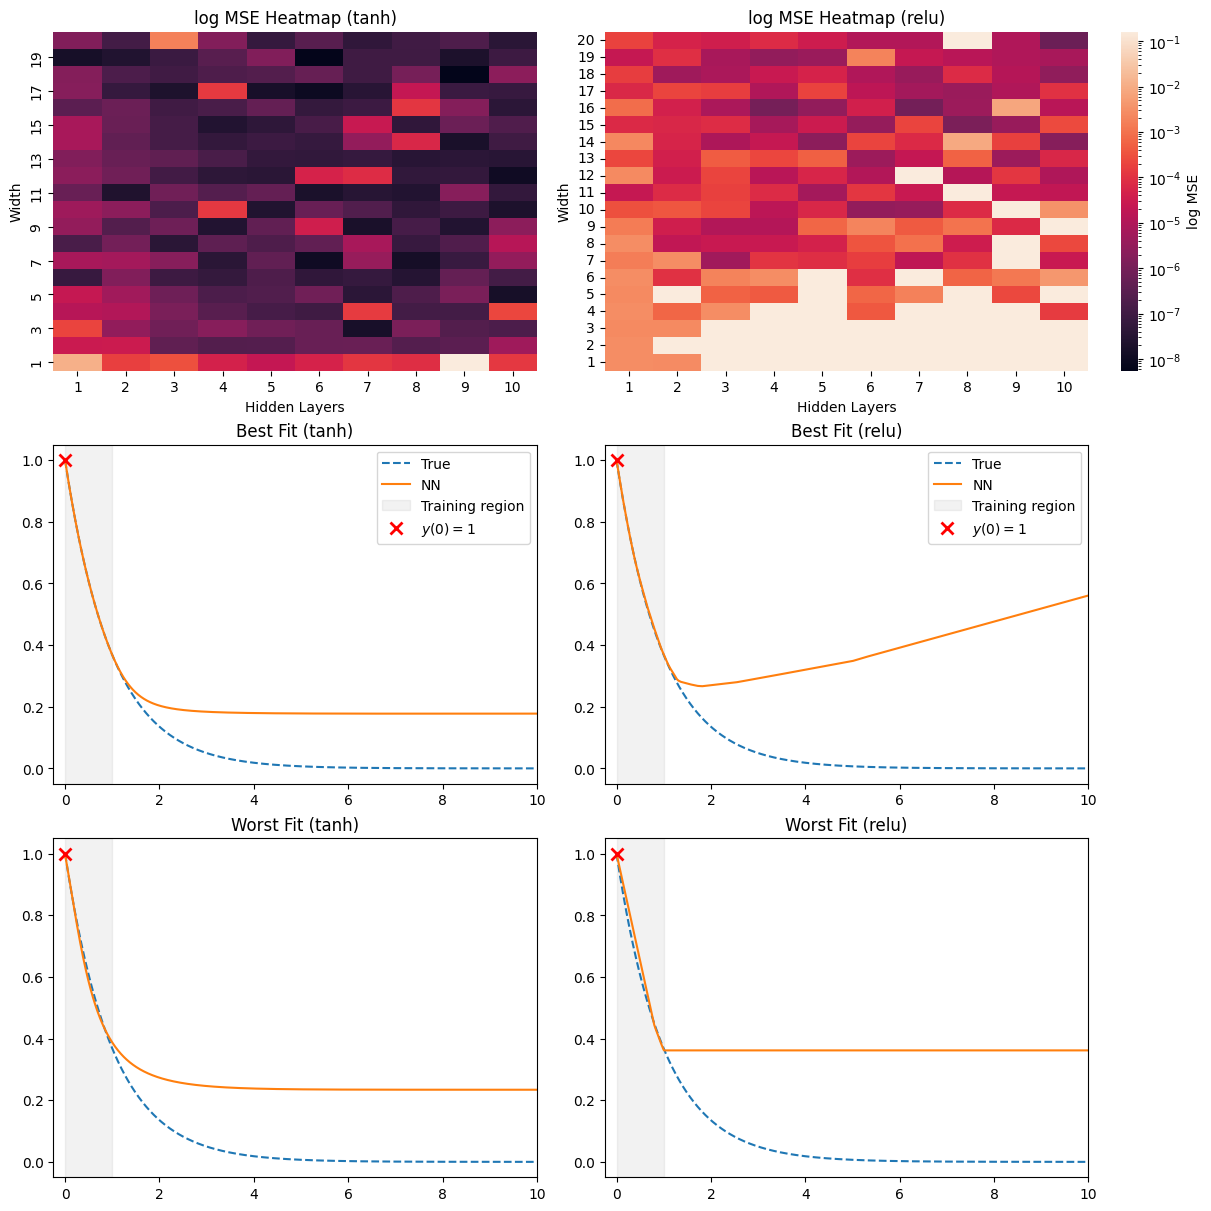

In [159]:
# Load your results
results_df = pd.read_csv("Data/IVP_data/exponential_decay_results.csv")

# Find shared color scale across heatmaps
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.LogNorm(vmin=global_min, vmax=global_max)

# Prepare best/worst configs
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_configs[act] = df_sub.loc[df_sub['mse'].idxmin()]
    worst_configs[act] = df_sub.loc[df_sub['mse'].idxmax()]

# Create combined plot (2 columns: tanh / relu; 3 rows: heatmap, best, worst)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

for j, act in enumerate(["tanh", "relu"]):
    # Heatmap 
    df_subset = results_df[results_df["activation"] == act]
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")

    sns.heatmap(
        heatmap_data,
        cmap="rocket",
        norm=log_norm,
        ax=axes[0, j],
        cbar=(j == 1),  # Only add colorbar on second plot
        cbar_kws={"label": "log MSE"}
    )
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Best Fit 
    config = best_configs[act]
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=int(config["layers"]),
                          hidden_units=int(config["width"]),
                          activation=act)
    train_ivp(model, epochs=2500, lr=1e-2, verbose=False)

    x = torch.linspace(0, 10, 1000).view(-1, 1)
    with torch.no_grad():
        y_pred = model(x).numpy()
    y_true = np.exp(-x.numpy())

    axes[1, j].plot(x.numpy(), y_true, "--", label="True")
    axes[1, j].plot(x.numpy(), y_pred, label="NN")
    axes[1, j].axvspan(0, 1, color="gray", alpha=0.1, label='Training region')
    axes[1, j].plot(0, 1, 'rx', label="$y(0)=1$", markersize=8, markeredgewidth=2)
    axes[1, j].set_title(f"Best Fit ({act})")
    axes[1, j].legend()
    axes[1, j].set_xlim(-0.25, 10)

    # Worst Fit
    config = worst_configs[act]
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=int(config["layers"]),
                          hidden_units=int(config["width"]),
                          activation=act)
    train_ivp(model, epochs=2500, lr=1e-2, verbose=False)

    with torch.no_grad():
        y_pred = model(x).numpy()

    axes[2, j].plot(x.numpy(), y_true, "--", label="True")
    axes[2, j].plot(x.numpy(), y_pred, label="NN")
    axes[2, j].plot(0, 1, 'rx', label="$y(0)=1$", markersize=8, markeredgewidth=2)
    axes[2, j].axvspan(0, 1, color="gray", alpha=0.1)
    axes[2, j].set_title(f"Worst Fit ({act})")
    # axes[2, j].legend()
    axes[2, j].set_xlim(-0.25, 10)

# Save full composite figure
# plt.suptitle("Comparison of NN Architectures for Exponential Decay", fontsize=14)
plt.savefig("report/graphics/ivp_exponential_combined.png", dpi=300, bbox_inches="tight")
plt.show()

Epoch 0: Total Loss = 2.096480, ODE = 0.514118, IC = 0.015824
Epoch 100: Total Loss = 0.498847, ODE = 0.498845, IC = 0.000000
Epoch 200: Total Loss = 0.480485, ODE = 0.480484, IC = 0.000000
Epoch 300: Total Loss = 0.455846, ODE = 0.455845, IC = 0.000000
Epoch 400: Total Loss = 0.426983, ODE = 0.426983, IC = 0.000000
Epoch 500: Total Loss = 0.402672, ODE = 0.402672, IC = 0.000000
Epoch 600: Total Loss = 0.380900, ODE = 0.380900, IC = 0.000000
Epoch 700: Total Loss = 0.362303, ODE = 0.362303, IC = 0.000000
Epoch 800: Total Loss = 0.350827, ODE = 0.350715, IC = 0.000001
Epoch 900: Total Loss = 0.345394, ODE = 0.345051, IC = 0.000003
Epoch 1000: Total Loss = 0.341806, ODE = 0.341805, IC = 0.000000
Epoch 1100: Total Loss = 0.339524, ODE = 0.339523, IC = 0.000000
Epoch 1200: Total Loss = 0.337715, ODE = 0.337714, IC = 0.000000
Epoch 1300: Total Loss = 0.336165, ODE = 0.336165, IC = 0.000000
Epoch 1400: Total Loss = 0.334814, ODE = 0.334750, IC = 0.000001
Epoch 1500: Total Loss = 0.333461, OD

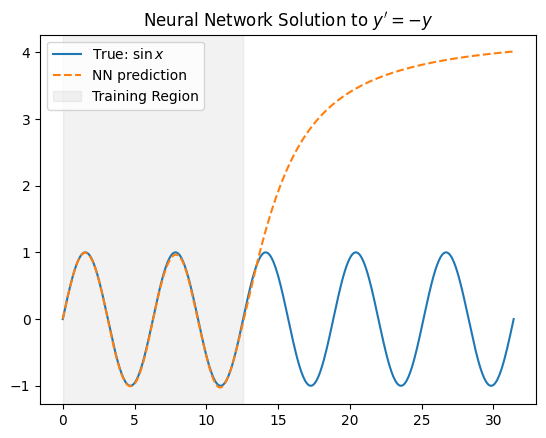

In [167]:
# Now I need to run the same analysis as earlier, but for the problem that contains a singularity. 
#  The problem now is: $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$.

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx - cos(x)
    ode_residual = dy_dx - torch.cos(x_collocation)
    loss_ode = torch.mean(ode_residual**2)

    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma * loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, epochs=2000, lr=1e-3, n_collocation=100, domain=(0.0, 0.99), verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_collocation = x_collocation.requires_grad_(True)

    # Initial condition remains at x = 0
    x_ic = torch.tensor([[domain[0]]], requires_grad=True)
    y_ic = torch.tensor([[0]])

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, ODE = {loss_ode:.6f}, IC = {loss_ic:.6f}")
        loss_history.append(loss.item())

    return loss_history

# sense check everythign above is setup correctly
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=3, hidden_units=18, activation='tanh')
train_ivp(model, epochs=20000, verbose=True, domain=(0.0, 4*np.pi))

x_test = torch.linspace(0.0, 10*np.pi, 500).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test)
y_true = torch.sin(x_test)

plt.plot(x_test.numpy(), y_true.numpy(), label='True: $\\sin x$')
plt.plot(x_test, y_pred, '--', label='NN prediction')
plt.axvspan(0, 4*np.pi, color='gray', alpha=0.1, label='Training Region')
plt.legend()
plt.title("Neural Network Solution to $y' = -y$")
plt.show()
    


In [177]:
# Ok we are ready to go. Let's now conduct the same big analysis and generate all these charts

# Now I will evaluate the best structure for fitting to this simple structure.
activations = ['tanh', 'relu']
layer_counts = [i for i in range(1, 11)]
widths = [i for i in range(1, 21)]

# Tracking results
results = []

# Loop through configurations
for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            
            start = time.time()
            train_ivp(model, epochs=5000, verbose=False, domain=(0.0, 4*np.pi))

            # Evaluate MSE on training domain
            x_eval = torch.linspace(0, 4*np.pi, 100).view(-1, 1)
            y_true = torch.sin(x_eval)
            with torch.no_grad():
                y_pred = model(x_eval)
                mse = torch.mean((y_pred - y_true)**2).item()
            duration = time.time() - start

            # Store results
            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("Data/IVP_data/periodic_results.csv", index=False)

Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

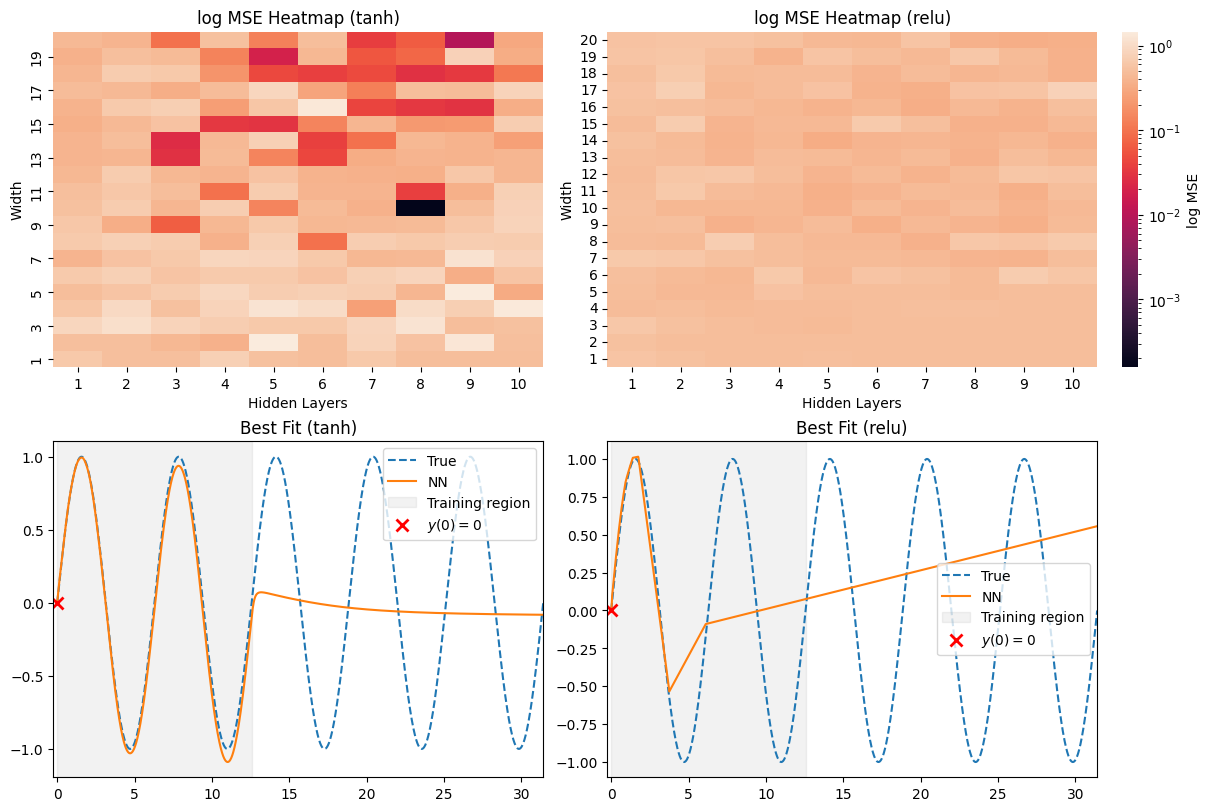

In [181]:
results_df = pd.read_csv("Data/IVP_data/periodic_results.csv")

# Shared log color scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.LogNorm(vmin=global_min, vmax=global_max)

# Best/worst configs
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_configs[act] = df_sub.loc[df_sub['mse'].idxmin()]
    worst_configs[act] = df_sub.loc[df_sub['mse'].idxmax()]

# Plotting layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

for j, act in enumerate(["tanh", "relu"]):
    # Heatmap 
    df_subset = results_df[results_df["activation"] == act]
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm, ax=axes[0, j],
                cbar=(j == 1), cbar_kws={"label": "log MSE"})
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Best Fit
    config = best_configs[act]
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=int(config["layers"]),
                          hidden_units=int(config["width"]),
                          activation=act)
    train_ivp(model, epochs=30000, lr=1e-3, verbose=False, domain=(0.0, 4*np.pi))

    x = torch.linspace(0.0, 10*np.pi, 2000).view(-1, 1)
    with torch.no_grad():
        y_pred = model(x).numpy()
    y_true = np.sin(x.numpy())

    axes[1, j].plot(x.numpy(), y_true, "--", label="True")
    axes[1, j].plot(x.numpy(), y_pred, label="NN")
    axes[1, j].axvspan(0, 4*np.pi, color="gray", alpha=0.1, label='Training region')
    axes[1, j].plot(0, 0, 'rx', label="$y(0)=0$", markersize=8, markeredgewidth=2)
    axes[1, j].set_title(f"Best Fit ({act})")
    axes[1, j].legend()
    axes[1, j].set_xlim([-0.25, 10*np.pi])

# Save figure
plt.savefig("report/graphics/ivp_periodic_combined.png", dpi=300, bbox_inches="tight")
plt.show()

Epoch 0: Total Loss = 93.508102
Epoch 500: Total Loss = 0.970423
Epoch 1000: Total Loss = 0.848533
Epoch 1500: Total Loss = 0.684178
Epoch 2000: Total Loss = 0.477641
Epoch 2500: Total Loss = 0.346545
Epoch 3000: Total Loss = 0.291447
Epoch 3500: Total Loss = 0.254988
Epoch 4000: Total Loss = 0.230481
Epoch 4500: Total Loss = 0.212929
Epoch 5000: Total Loss = 0.199958
Epoch 5500: Total Loss = 0.189692
Epoch 6000: Total Loss = 0.181332
Epoch 6500: Total Loss = 0.174068
Epoch 7000: Total Loss = 0.167666
Epoch 7500: Total Loss = 0.161764
Epoch 8000: Total Loss = 0.156050
Epoch 8500: Total Loss = 0.150005
Epoch 9000: Total Loss = 0.143352
Epoch 9500: Total Loss = 0.135035
Epoch 10000: Total Loss = 0.125112
Epoch 10500: Total Loss = 0.113992
Epoch 11000: Total Loss = 0.103671
Epoch 11500: Total Loss = 0.096304
Epoch 12000: Total Loss = 0.091708
Epoch 12500: Total Loss = 0.092270
Epoch 13000: Total Loss = 0.085954
Epoch 13500: Total Loss = 0.083690
Epoch 14000: Total Loss = 0.081623
Epoch 14

/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_60736/2851970177.py:56: RuntimeWarning: divide by zero encountered in divide
  y_true = 1 / (1 - x_plot_np)


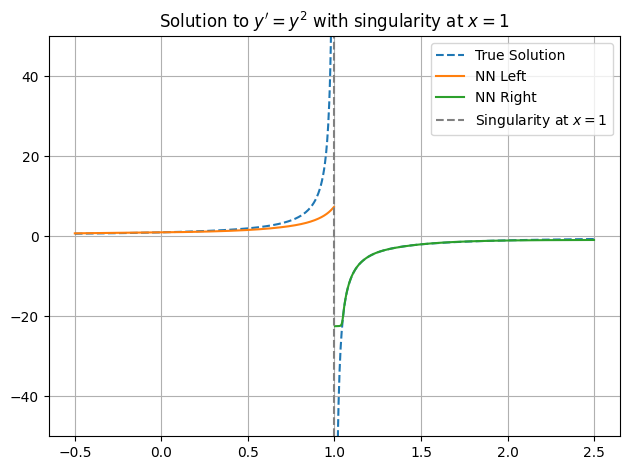

In [182]:
# Now I need to run the same analysis as earlier, but for the problem that contains a singularity. 
#  The problem now is: $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$.

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx - cos(x)
    ode_residual = dy_dx - y_pred**2
    loss_ode = torch.mean(ode_residual**2)

    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma * loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, y0, x0, domain, epochs=3000, lr=1e-3, n_collocation=100, verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_ic = torch.tensor([[x0]], dtype=torch.float32)
    y_ic = torch.tensor([[y0]], dtype=torch.float32)

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}")
        loss_history.append(loss.item())

    return loss_history

# sense check everythign above is setup correctly
# Train on both sides

# Left side of singularity (0 < x < 1)
model_left = FeedforwardNN(1, 1, hidden_layers=3, hidden_units=20, activation='tanh')
train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.99), n_collocation=300, epochs=20000)

# Right side of singularity (x > 1), initial condition y(1.05) = 1 / (1 - 1.05) = -20
model_right = FeedforwardNN(1, 1, hidden_layers=3, hidden_units=20, activation='tanh')
train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), n_collocation=300)

x_plot = torch.linspace(-0.5, 2.5, 1001).view(-1, 1)
x_plot_np = x_plot.numpy()
y_true = 1 / (1 - x_plot_np)

with torch.no_grad():
    y_left = model_left(x_plot[x_plot[:, 0] < 1])
    y_right = model_right(x_plot[x_plot[:, 0] > 1])

plt.plot(x_plot_np, y_true, '--', label='True Solution')
plt.plot(x_plot_np[x_plot_np[:, 0] < 1], y_left.numpy(), label='NN Left')
plt.plot(x_plot_np[x_plot_np[:, 0] > 1], y_right.numpy(), label='NN Right')
plt.axvline(1.0, color='gray', linestyle='--', label='Singularity at $x=1$')
plt.ylim((-50, 50))
plt.grid(True)
plt.legend()
plt.title("Solution to $y' = y^2$ with singularity at $x=1$")
plt.tight_layout()
plt.show()

In [183]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))
widths = list(range(1, 21))

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            start = time.time()

            # --- Left model: train on [0, 0.95], with y(0) = 1
            model_left = FeedforwardNN(
                input_dim=1,
                output_dim=1,
                hidden_layers=layers,
                hidden_units=width,
                activation=act
            )
            train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.95), epochs=2500, verbose=False)

            # --- Right model: train on [1.05, 2.0], with y(1.05) = 1 / (1 - 1.05) = -20
            model_right = FeedforwardNN(
                input_dim=1,
                output_dim=1,
                hidden_layers=layers,
                hidden_units=width,
                activation=act
            )
            train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), epochs=2500, verbose=False)

            # --- Evaluate on both sides
            x_eval_left = torch.linspace(0.0, 0.95, 100).view(-1, 1)
            x_eval_right = torch.linspace(1.05, 2.0, 100).view(-1, 1)
            y_true_left = 1 / (1 - x_eval_left)
            y_true_right = 1 / (1 - x_eval_right)

            with torch.no_grad():
                y_pred_left = model_left(x_eval_left)
                y_pred_right = model_right(x_eval_right)

            mse_left = torch.mean((y_pred_left - y_true_left)**2).item()
            mse_right = torch.mean((y_pred_right - y_true_right)**2).item()
            total_mse = mse_left + mse_right

            duration = time.time() - start

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": total_mse,
                "mse_left": mse_left,
                "mse_right": mse_right,
                "train_time_sec": duration
            })


results_df = pd.DataFrame(results)
results_df.to_csv("Data/IVP_data/singularity_data.csv", index=False)

Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

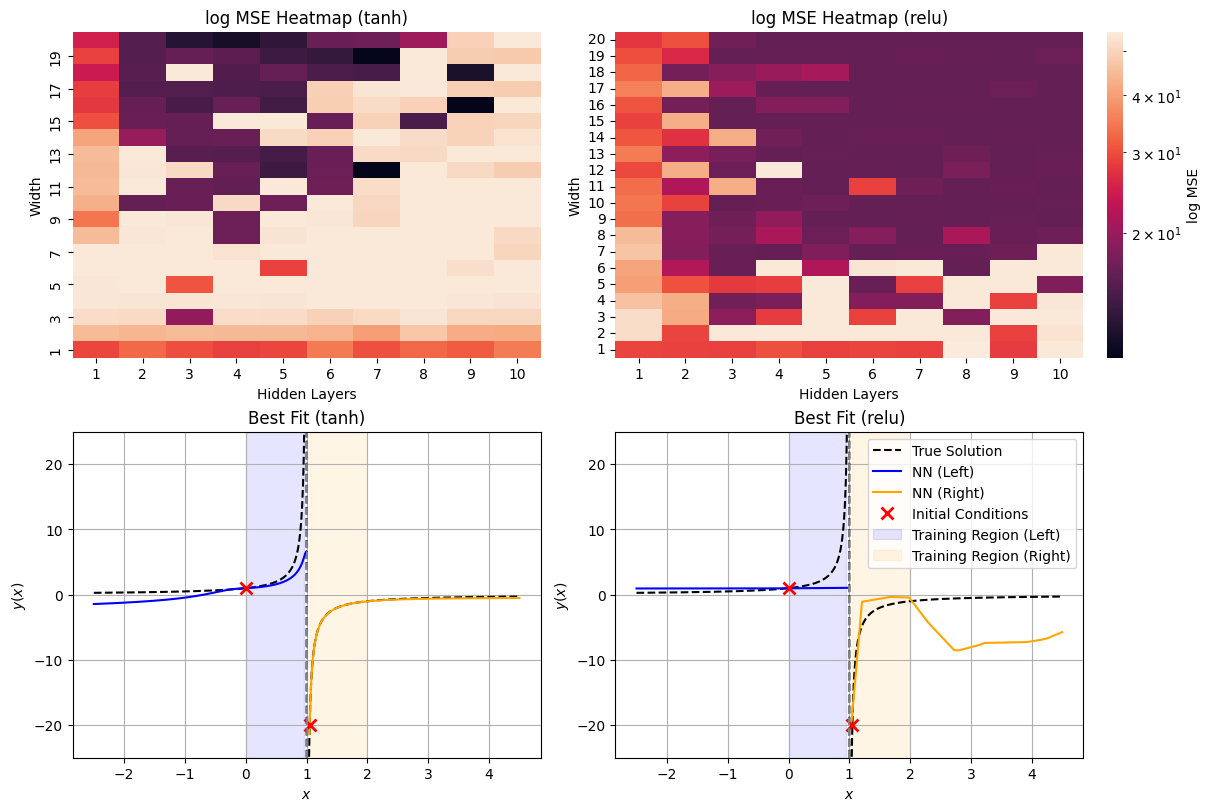

In [189]:
results_df = pd.read_csv("Data/IVP_data/singularity_data.csv")

# Identify global min/max for shared colour scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.LogNorm(vmin=global_min, vmax=global_max)

# Find best fits
best_configs = {}
for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_configs[act] = df_sub.loc[df_sub['mse'].idxmin()]

# Setup figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

for j, act in enumerate(["tanh", "relu"]):
    # Heatmap
    df_subset = results_df[results_df["activation"] == act]
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")

    sns.heatmap(
        heatmap_data,
        cmap="rocket",
        norm=log_norm,
        ax=axes[0, j],
        cbar=(j == 1),
        cbar_kws={"label": "log MSE"}
    )
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Best configuration
    config = best_configs[act]
    layers = int(config['layers'])
    width = int(config['width'])

    # Train models on left and right of singularity
    model_left = FeedforwardNN(1, 1, layers, width, activation=act)
    model_right = FeedforwardNN(1, 1, layers, width, activation=act)
    train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.95), epochs=10000, verbose=False)
    train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), epochs=10000, verbose=False)

    # Prepare test data
    x_test = torch.linspace(-2.5, 4.5, 1000).view(-1, 1)
    x_np = x_test.numpy()
    y_true = 1 / (1 - x_np)

    with torch.no_grad():
        mask_left = x_test[:, 0] < 1
        mask_right = x_test[:, 0] > 1
        y_pred_left = model_left(x_test[mask_left])
        y_pred_right = model_right(x_test[mask_right])

    # Plot best fit
    ax = axes[1, j]
    ax.plot(x_np, y_true, "--", label="True Solution", color="black")
    ax.plot(x_np[mask_left], y_pred_left.numpy(), label="NN (Left)", color="blue")
    ax.plot(x_np[mask_right], y_pred_right.numpy(), label="NN (Right)", color="orange")
    ax.plot([0, 1.05], [1, -20], 'rx', label="Initial Conditions", markersize=8, markeredgewidth=2)
    ax.axvline(1.0, linestyle="--", color="gray")
    ax.axvspan(0.0, 0.95, alpha=0.1, color="blue", label="Training Region (Left)")
    ax.axvspan(1.05, 2.0, alpha=0.1, color="orange", label="Training Region (Right)")
    ax.set_ylim([-25, 25])
    ax.set_title(f"Best Fit ({act})")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y(x)$")
    ax.grid(True)

    if j == 1:
        ax.legend(loc="upper right")

plt.savefig("report/graphics/ivp_singularity_combined.png", dpi=300, bbox_inches="tight")
plt.show()
